In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam
import plotly.graph_objs as go
import folium

from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests



%matplotlib inline

Using TensorFlow backend.


In [2]:
india_data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
df_india = pd.io.json.json_normalize(india_data_json['data']['statewise'])
df_india = df_india.set_index("state")

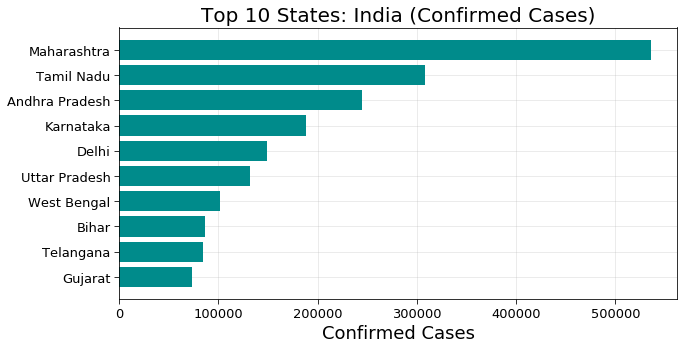

In [3]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('confirmed')["confirmed"].index[-10:],df_india.sort_values('confirmed')["confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 States: India (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)

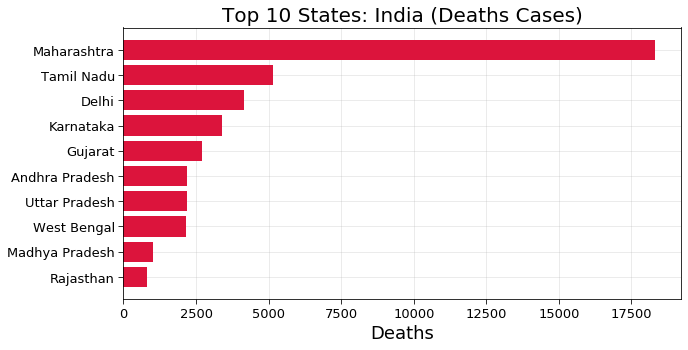

In [4]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('deaths')["deaths"].index[-10:],df_india.sort_values('deaths')["deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Top 10 States: India (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3)

In [8]:
locations = {
    "Kerala" : [10.8505,76.2711],
    "Maharashtra" : [19.7515,75.7139],
    "Karnataka": [15.3173,75.7139],
    "Telangana": [18.1124,79.0193],
    "Uttar Pradesh": [26.8467,80.9462],
    "Rajasthan": [27.0238,74.2179],
    "Gujarat":[22.2587,71.1924],
    "Delhi" : [28.7041,77.1025],
    "Punjab":[31.1471,75.3412],
    "Tamil Nadu": [11.1271,78.6569],
    "Haryana": [29.0588,76.0856],
    "Madhya Pradesh":[22.9734,78.6569],
    "Jammu and Kashmir":[33.7782,76.5762],
    "Ladakh": [34.1526,77.5770],
    "Andhra Pradesh":[15.9129,79.7400],
    "West Bengal": [22.9868,87.8550],
    "Bihar": [25.0961,85.3131],
    "Chhattisgarh":[21.2787,81.8661],
    "Chandigarh":[30.7333,76.7794],
    "Uttarakhand":[30.0668,79.0193],
    "Himachal Pradesh":[31.1048,77.1734],
    "Goa": [15.2993,74.1240],
    "Odisha":[20.9517,85.0985],
    "Andaman and Nicobar Islands": [11.7401,92.6586],
    "Puducherry":[11.9416,79.8083],
    "Manipur":[24.6637,93.9063],
    "Mizoram":[23.1645,92.9376],
    "Assam":[26.2006,92.9376],
    "Meghalaya":[25.4670,91.3662],
    "Tripura":[23.9408,91.9882],
    "Arunachal Pradesh":[28.2180,94.7278],
    "Jharkhand" : [23.6102,85.2799],
    "Nagaland": [26.1584,94.5624],
    "Sikkim": [27.5330,88.5122],
    "Dadra and Nagar Haveli":[20.1809,73.0169],
    "Lakshadweep":[10.5667,72.6417],
    "Daman and Diu":[20.4283,72.8397]    
}
df_india["Lat"] = ""
df_india["Long"] = ""

for index in df_india.index :
    if index in locations:
        df_india.loc[df_india.index == index,"Lat"] = locations[index][0]
        df_india.loc[df_india.index == index,"Long"] = locations[index][1]
    else:
        df_india.drop([index],inplace=True)

In [9]:
india = folium.Map(location=[20.5937, 78.9629], zoom_start=14,max_zoom=4,min_zoom=3, 
                   tiles = "CartoDB dark_matter",detect_retina = True,height = 600,width = '70%')
for i in range(0,len(df_india[df_india['confirmed']>0].index)):
    folium.Circle(
        location=[df_india.iloc[i]['Lat'], df_india.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_india.iloc[i].name+"</h5>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_india.iloc[i]['confirmed'])+"</li>"+
        "<li>Active:   "+str(df_india.iloc[i]['active'])+"</li>"+
        "<li>Recovered:   "+str(df_india.iloc[i]['recovered'])+"</li>"+
        "<li>Deaths:   "+str(df_india.iloc[i]['deaths'])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_india.iloc[i]['deaths']/(df_india.iloc[i]['confirmed']+1)*100,2))+"</li>"+
        "</ul>",
        radius=(int(np.log2(df_india.iloc[i]['confirmed']+1)))*9000,
        color='red',
        fill_color='green',
        fill=True).add_to(india)
india

In [10]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import mean_squared_error
import numpy as np
from copy import deepcopy
from numpy import inf
from math import exp
from datetime import timedelta
from sklearn.metrics import r2_score
from scipy.special import softmax
import warnings
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objects import Layout
from datetime import datetime, date

In [11]:
warnings.simplefilter("ignore")

In [12]:
try:
    os.makedirs('plots')
except OSError as e:
    pass


In [13]:
pwd

'C:\\Users\\Dell'

In [14]:
df = pd.read_csv( 'owid-covid-data.csv' )
df['date'] = pd.to_datetime(df.date)

In [15]:
countries = list(pd.unique(df['location']))


In [16]:
def weib(x, k, a, b, g):
    return k * g * b * (a ** b) * np.exp(-1 * g * ((a / x)  ** b)) / (x ** (b + 1))




In [17]:
def getInfoCountry(df2, isdead):
    df2['Delta'] = (df2.date - min(df2.date)).dt.days
    startDate = min(df2.date)
    totalLength = max(df2.Delta)
    confirmed = []; new = []
    df2 = df2.fillna(0)
    for day in range(totalLength):
        newc = max(0, int(sum(df2.new_cases[df2.Delta == day] if not isdead else df2.new_deaths[df2.Delta == day])))
        new.append(newc)
        confirmed.append(new[-1] + (confirmed[-1] if len(confirmed) > 1 else 0))
    return startDate, totalLength, confirmed, new

In [18]:
def totalExpected(func, popt, data):
    total = 0; day = 1
    while True:
        today = func(day, *popt) if day >= len(data) else data[day]
        total += today
        day += 1
        if day > data.index(max(data)) and today <= 1: break
    return day, total


In [19]:
def calcWhen(func, popt, match, data):
    total = 0; day = 1
    while True:
        today = func(day, *popt) if day >= len(data) else data[day]
        total += today
        day += 1
        if total >= match or (today == 0 and day > data.index(max(data))): break
    return day


In [20]:
def iterativeCurveFit(func, x, y, start):
	outliersweight = None
	for i in range(10):
		popt, pcov = curve_fit(func, x, y, start, sigma=outliersweight, maxfev=100000)
		pred = np.array([func(px, *popt) for px in x])
		old = outliersweight
		outliersweight = np.abs(pred - y)
		outliersweight = outliersweight - np.tanh(outliersweight)
		outliersweight = outliersweight / np.max(outliersweight)
		outliersweight = softmax(1 - outliersweight)
		if i > 1 and sum(abs(old - outliersweight)) < 0.001: break
	return popt, pcov

In [21]:
def seriesIterativeCurveFit(func, xIn, yIn, start):
	res = []; errors = []
	for ignore in range(10, 0, -1):
		x = xIn[:-1*ignore]; y = yIn[:-1*ignore]
		outliersweight = None
		for i in range(10):
			try:
				popt, pcov = curve_fit(func, x, y, start, sigma=outliersweight, absolute_sigma=True, maxfev=500000)
			except Exception as e: 
				print('ignore -', ignore, ', exception -', e)
				break
			pred = np.array([func(px, *popt) for px in x])
			old = outliersweight
			outliersweight = np.abs(pred - y)
			outliersweight = outliersweight / np.max(outliersweight)
			outliersweight = outliersweight - np.tanh(outliersweight)
			outliersweight = softmax(1 - outliersweight)
			if i > 1 and sum(abs(old - outliersweight)) < 0.001: break
		pred = [func(px, *popt) for px in xIn]
		res.append((popt, pcov, ignore))
		errors.append(mean_absolute_percentage_error(yIn, pred))
	print(errors)
	val = res[errors.index(min(errors))]
	return val[0], val[1]

In [22]:
def getMaxCases(y, data):
	m = 0; dday = 0
	for day,cases in enumerate(y):
		if day < len(data):
			if data[day] > m:
				m = data[day]; dday = day
		else:
			if cases > m:
				m = cases; dday = day
	return m, dday

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
	return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / (np.array(y_true)+1))) * 100

In [24]:
def getcummulative(l):
	res = []; s = 0
	for i in l:
		s += i; res.append(s)
	return res

In [25]:
dead = False
finaldata = []
dfPlot = pd.DataFrame()
dfcPlot = pd.DataFrame()
training_data = -1
interactive = ['India', 'World', 'United States', 'United Kingdom', 'Brazil', 'Italy', 'France', 'Germany', 'Russia']
for country in interactive:
	try:
		dead = False
		print("--", country)
		df2 = df[df['location'] == country]
		res = getInfoCountry(df2, False)
		data = res[-1]
		days = res[1]
		start = res[0]

		func = [(weib, [0, 20, 100]), (weib, [60000, 14, 4, 500]), (weib, [7000, 0.5, 0.001, 100])]

		whichFunc = 1
		times = 2; skip = 30
		datacopy = deepcopy(data[1:training_data]); x = list(range(len(data)))
		if country == 'China': datacopy[datacopy == 15141] = 4000
		popt, pcov = seriesIterativeCurveFit(func[whichFunc][0], x[1:training_data], datacopy, func[whichFunc][1])
		finalday, finalexp = totalExpected(func[whichFunc][0], popt, data)
		when97 = calcWhen(func[whichFunc][0], popt, 0.97 * finalexp, data)

		when97 = 1000 if when97 > 1000 else when97
		xlim = max(len(data)*times, when97+10)
		pred = [func[whichFunc][0](px, *popt) for px in list(range(xlim))[1:]]

		y = [func[whichFunc][0](px, *popt) for px in list(range(xlim))[1:]]
		maxcases, maxday = getMaxCases(y, data)
		newpredsave = deepcopy(y)
		newsave = deepcopy(data)
		cumpredsave = getcummulative(y)
		cumsave = getcummulative(data)

		dead = True
		res = getInfoCountry(df2, True)
		data = res[-1]
		deadsave = deepcopy(data)

		xlim2 = max(len(data)*times, when97+10)
		xlim = max(xlim, xlim2)

		datacopy = np.absolute(np.array(deepcopy(data[1:training_data])))
		poptold = popt
		finalexpold = finalexp
		popt, pcov = seriesIterativeCurveFit(func[whichFunc][0], x[1:training_data], datacopy, [2000, 54, 4, 500])
		y = [func[1][0](px, *popt) for px in x[1:]]
		pred = [func[whichFunc][0](px, *popt) for px in list(range(xlim2))[1:]]
		deadpredsave = deepcopy(pred)

		cumdpredsave = getcummulative(deadpredsave)
		cumdsave = getcummulative(deadsave)
		newdf = pd.DataFrame.from_dict({country+'-pred': newpredsave, \
			country+'-dates':[(start+timedelta(days=i)).strftime("%d %b %Y") for i in list(range(1,xlim))], \
			country+'-true': newsave,\
			country+'-cum': cumpredsave,\
			country+'-predd': deadpredsave,\
			country+'-trued': deadsave}, orient='index').T
		dfPlot[country+'-pred'] = pd.Series(newdf[country+'-pred'])
		dfPlot[country+'-dates'] = pd.Series(newdf[country+'-dates'])
		dfPlot[country+'-true'] = pd.Series(newdf[country+'-true'])
		dfPlot[country+'-cum'] = pd.Series(newdf[country+'-cum'])
		dfPlot[country+'-predd'] = pd.Series(newdf[country+'-predd'])
		dfPlot[country+'-trued'] = pd.Series(newdf[country+'-trued'])
		newcdf = pd.DataFrame.from_dict({country+'-dates':[(start+timedelta(days=i)).strftime("%d %b %Y") for i in list(range(1,xlim))], \
			country+'-cpred': cumpredsave, \
			country+'-ctrue': cumsave,\
			country+'-cpredd': cumdpredsave,\
			country+'-ctrued': cumdsave}, orient='index').T
		dfcPlot[country+'-dates'] = pd.Series(newcdf[country+'-dates'])
		dfcPlot[country+'-pred'] = pd.Series(newcdf[country+'-cpred'])
		dfcPlot[country+'-true'] = pd.Series(newcdf[country+'-ctrue'])
		dfcPlot[country+'-cpredd'] = pd.Series(newcdf[country+'-cpredd'])
		dfcPlot[country+'-ctrued'] = pd.Series(newcdf[country+'-ctrued'])
		dates = [(start+timedelta(days=i)).strftime("%d %b %Y") for i in list(range(1,xlim))]
		fig = make_subplots(specs=[[{"secondary_y": True}]])
		fig.add_trace(go.Scatter(x=dates, y=newpredsave, name="Prediction (new cases)", marker=dict(color='#EB752C')))
		fig.add_trace(go.Bar(x=dates, y=newsave, name="True data (new cases)", marker=dict(color='#EB752C'), opacity=0.7, width=[1]*len(dates), hoverlabel=dict(bgcolor='#FF351C')))
		fig.add_trace(go.Scatter(x=dates, y=deadpredsave, name="Prediction (deaths)", marker=dict(color='#2D58BE')), secondary_y=True)
		fig.add_trace(go.Bar(x=dates, y=deadsave, name="True data (deaths)", marker=dict(color='#2D58BE'), opacity=0.3, width=[1]*len(dates), hoverlabel=dict(bgcolor='#1A22AB')), secondary_y=True)
		fig.update_layout(hovermode="x",
			title=country.capitalize(),
			title_x=0.5,
			title_font=dict(size=20),
			xaxis_title='Date',
			font=dict(family='Overpass', size=12, color='#212121'),
			yaxis_tickformat = ',.0f',
			xaxis = dict(dtick = 30),
			autosize=False,
		    width=700,
		    height=500,
		    legend=dict(x=0.6, y=0.9, bordercolor='Black', borderwidth=1),
		    plot_bgcolor='rgba(0,0,0,0)',
			)
		fig.update_yaxes(title_text="Number of daily new cases", gridcolor='lightgray', showline=True, linewidth=3, linecolor='orange', gridwidth=1, secondary_y=False,)
		fig.update_yaxes(tickformat = ',.0f',title_text="Number of daily deaths", secondary_y=True, gridcolor='lightgray', showline=True, linewidth=3, linecolor='blue', gridwidth=1)
		fig.write_html("plots/"+country+"_pred"+".html")
		####
		fig = make_subplots(specs=[[{"secondary_y": True}]])
		fig.add_trace(go.Scatter(x=dates, y=cumpredsave, name="Prediction (new cases)", marker=dict(color='#EB752C')))
		fig.add_trace(go.Bar(x=dates, y=cumsave, name="True data (new cases)", marker=dict(color='#EB752C'), opacity=0.7, width=[1]*len(dates), hoverlabel=dict(bgcolor='#FF351C')))
		fig.add_trace(go.Scatter(x=dates, y=cumdpredsave, name="Prediction (deaths)", marker=dict(color='#2D58BE')), secondary_y=True)
		fig.add_trace(go.Bar(x=dates, y=cumdsave, name="True data (deaths)", marker=dict(color='#2D58BE'), opacity=0.3, width=[1]*len(dates), hoverlabel=dict(bgcolor='#1A22AB')), secondary_y=True)
		fig.update_layout(hovermode="x",
			title=country.capitalize(),
			title_x=0.5,
			title_font=dict(size=20),
			xaxis_title='Date',
			font=dict(family='Overpass', size=12, color='#212121'),
			yaxis_tickformat = ',.0f',
			xaxis = dict(dtick = 30),
			autosize=False,
		    width=700,
		    height=500,
		    legend=dict(x=0.6, y=0.3, bordercolor='Black', borderwidth=1),
		    plot_bgcolor='rgba(0,0,0,0)',
			)
		fig.update_yaxes(title_text="Number of total cases", gridcolor='lightgray', showline=True, linewidth=3, linecolor='orange', gridwidth=1, secondary_y=False,)
		fig.update_yaxes(tickformat = ',.0f',title_text="Number of total deaths", secondary_y=True, gridcolor='lightgray', showline=True, linewidth=3, linecolor='blue', gridwidth=1)
		fig.write_html("plots/"+country+"_total"+".html")
		fig.data = []
	except Exception as e:
		print(str(e))
		# raise(e)
		pass

f = open("plots.txt", "w")
now = datetime.now().time()
today = date.today()
f.write(now.strftime("%H:%M:%S")+" - "+today.strftime("%d %b %Y"))
f.close()
#dfPlot.to_excel('plot.xlsx')
#dfcPlot.to_excel('cplot.xlsx')

-- India
[76838.9976108422, 76834.22388190457, 76828.16941271104, 76831.09010056607, 76817.33191813287, 76816.74227505607, 76807.96590397968, 76804.9211090065, 76800.34525584207, 76793.23933901919]
[143.66861704838908, 143.83921857724891, 143.6143476280592, 143.6651732506521, 143.65782733399246, 143.6194472063794, 143.8150621639223, 143.7713727115064, 143.7785880910886, 143.81000152017415]
-- World
[1216348.387522308, 1215410.753491581, 1214322.7286685624, 1213378.2513778112, 1212372.422875315, 1211474.4301933523, 1210511.191043099, 1209612.0868502788, 1208957.2396206325, 1208900.856014698]
[50011.088877093825, 49986.958141953604, 49963.75902810654, 49937.930126805455, 49915.96570028894, 49885.52011695327, 49864.636728188496, 49850.91020820264, 49832.2982030027, 49833.33341828762]
-- United States
[309074.7872972381, 308857.9909855648, 308633.4690476324, 308429.2879899577, 308226.02213863825, 308006.9213421779, 307827.1297964828, 307628.8330284852, 307450.39780501137, 307321.7082875800

In [26]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import mean_squared_error
import numpy as np
from copy import deepcopy
#import torch.nn.functional as F
from numpy import inf
from math import exp, gamma
from datetime import timedelta
from sklearn.metrics import r2_score
import matplotlib.patheffects as PathEffects
from scipy.special import softmax
import warnings
import os
from tqdm import tqdm
import math
from scipy.stats import pearsonr, spearmanr

In [27]:
warnings.simplefilter("ignore")

#plt.style.use(['science'])
#plt.rcParams["text.usetex"] = True

df = pd.read_csv('state_wise_daily.csv')
df['date'] = pd.to_datetime(df.Date)

def gauss(x, mu, sigma, scale):
    return scale * np.exp(-1 * ((x - mu) ** 2) / (2 * (sigma ** 2) )) 

def weib(x, k, a, b, g):
	return k * g * b * (a ** b) * np.exp(-1 * g * ((a / x)  ** b)) / (x ** (b + 1))

def beta(x, k, a, b, p, q):
	return k * gamma(p + q) * ((x - a)** (p-1)) * (b-x)**(q-1) / (gamma(p) * gamma(q) * (b-a)**(p+q-1))

def ft(x, k, e, d, o):
	return k * np.exp(-1 * (1 + e * (x-o)) ** (-1 / (e + d)))


In [28]:
def getInfoCountry(df2, isdead):
	df2['Delta'] = (df2.date - min(df2.date)).dt.days
	startDate = min(df2.date)
	totalLength = max(df2.Delta)
	confirmed = []; new = []
	cols = list(df2.columns)[2:-2]
	for day in range(int(totalLength)):
		newc = int(df2[cols][df2.Delta == day][df.Status == ('Confirmed' if not isdead else 'Deceased')].sum(axis=1))
		new.append(newc)
		confirmed.append(new[-1] + (confirmed[-1] if len(confirmed) > 1 else 0))
	return startDate, totalLength, confirmed, new


In [29]:
def totalExpected(func, popt, data):
	total = 0; day = 1
	while True:
		today = func(day, *popt) if day >= len(data) else data[day]
		total += today
		day += 1
		if (day > len(data) and today <= 1) or day > 1000: break
	return day, total

In [30]:
def calcWhen(func, popt, match, data):
	total = 0; day = 1
	while True:
		today = func(day, *popt) if day >= len(data) else data[day]
		total += today
		day += 1
		if total >= match or (today == 0 and day > data.index(max(data))): break
	return day

In [31]:
def iterativeCurveFit(func, x, y, start):
	outliersweight = None
	for i in range(10):
		popt, pcov = curve_fit(func, x, y, start, sigma=outliersweight, maxfev=100000)
		pred = np.array([func(px, *popt) for px in x])
		old = outliersweight
		outliersweight = np.abs(pred - y)
		outliersweight = outliersweight - np.tanh(outliersweight)
		outliersweight = outliersweight / np.max(outliersweight)
		outliersweight = softmax(1 - outliersweight)
		if i > 1 and sum(abs(old - outliersweight)) < 0.001: break
	return popt, pcov


In [32]:
def seriesIterativeCurveFit(func, xIn, yIn, start):
	res = []
	for ignore in tqdm(list(range(10, 0, -1)), ncols=80):
		x = xIn[:-1*ignore]; y = yIn[:-1*ignore]
		outliersweight = None
		for i in range(10):
			popt, pcov = curve_fit(func, x, y, start, sigma=outliersweight, absolute_sigma=True, maxfev=1000000)
			pred = np.array([func(px, *popt) for px in x])
			old = outliersweight
			outliersweight = np.abs(pred - y)
			outliersweight = outliersweight - np.tanh(outliersweight)
			outliersweight = outliersweight / np.max(outliersweight)
			outliersweight = softmax(1 - outliersweight)
			if i > 1 and sum(abs(old - outliersweight)) < 0.001: break
		pred = [func(px, *popt) for px in xIn]
		res.append((mean_absolute_percentage_error(yIn, pred), popt, pcov, ignore))
	# for i in res: print(i)
	errors = [i[0] for i in res]
	val = res[errors.index(min(errors))]
	return val[1], val[2]


In [33]:
def getMaxCases(y, data):
	m = 0; dday = 0
	for day,cases in enumerate(y):
		# if day < len(data):
		# 	if data[day] > m:
		# 		m = data[day]; dday = day
		# else:
			if cases > m:
				m = cases; dday = day
	return m, dday

-- India


100%|███████████████████████████████████████████| 10/10 [12:27<00:00, 67.19s/it]


MSE  7.185704e+06
R2  0.9224545576805623
97 day 09 Dec 22
MAPE 18.820184385612823


100%|███████████████████████████████████████████| 10/10 [06:46<00:00, 44.83s/it]


---- India


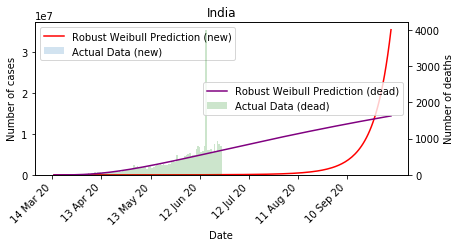

In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / (np.array(y_true)+1))) * 100

insufficient = ['Central African Republic', 'Cambodia', 'Sudan', 'Ecuador', 'Chile', 'Colombia', 'Peru'] 
finaldata = []; gooddataNew = []; gooddataDead = []
ignore = -1
training_data = -15
for country in ['India']:
	if country in insufficient:
		continue
	try:
		dead = False
		print("--", country)
		df2 = df
		res = getInfoCountry(df2, False)
		data = res[-1]
		days = res[1]
		start = res[0]

		func = [(gauss, [0, 20, 100]), (weib, [160000, 14, 4, 500]), (ft, [7000, 0.5, 0.001, 100])]

		whichFunc = 0
		times = 2; skip = 30
		plt.figure(figsize=(6,3))
		x = list(range(len(data)))
		datacopy = np.absolute(np.array(deepcopy(data[1:training_data])))
		if country == 'China': datacopy[datacopy == 15141] = 4000
		# poptg, pcovg = curve_fit(func[whichFunc][0], x[1:training_data], datacopy, func[whichFunc][1], maxfev=100000)
		whichFunc = 1
		popt, pcov = seriesIterativeCurveFit(func[whichFunc][0], x[1:training_data], datacopy, func[whichFunc][1])
		finalday, finalexp = totalExpected(func[whichFunc][0], popt, data)
		when97 = calcWhen(func[whichFunc][0], popt, 0.97 * finalexp, data)

		when97 = 1000 if when97 > 1000 else when97
		xlim = max(len(data)*times, 180)
		pred = [func[whichFunc][0](px, *popt) for px in list(range(xlim))[1:]]

		plt.plot(list(range(xlim))[1:], pred, color='red', label='Robust Weibull Prediction (new)')
		_ = plt.bar(x, data, width=1, edgecolor='black', linewidth=0.01, alpha=0.2, label='Actual Data (new)')
		plt.ylabel("Number of cases"); plt.xlabel("Date"); plt.tight_layout(); 
		plt.legend(loc='best');	plt.title(country)

		y = [func[1][0](px, *popt) for px in x[1:]]
		r2 = r2_score(data[1:], y)
		mape = mean_absolute_percentage_error(data[1:], y)

		print("MSE ", "{:e}".format(mean_squared_error(data[1:], y)))
		print("R2 ", r2)
		print("97 day", (start + timedelta(days=when97)).strftime("%d %b %y"))
		print("MAPE", mape)
		mape_error_new = mean_absolute_percentage_error(data[training_data:], y[training_data:])
		r2_error_new = r2_score(data[training_data:], y[training_data:])

		# Metrics
		y = [func[whichFunc][0](px, *popt) for px in list(range(xlim))[1:]]
		maxcases, maxday = getMaxCases(y, data)

		dead = True
		res = getInfoCountry(df2, True)
		data = res[-1]

		xlim2 = max(len(data)*times, 180)

		xlim = max(xlim, xlim2)
		plt.xticks(list(range(0,xlim,30)), [(start+timedelta(days=i)).strftime("%d %b %y") for i in range(0,xlim,skip)], rotation=45, ha='right')
		plt.twinx()

		datacopy = np.absolute(np.array(deepcopy(data[1:training_data])))
		poptold = popt
		finalexpold = finalexp
		popt, pcov = seriesIterativeCurveFit(func[whichFunc][0], x[1:training_data], datacopy, [160000, 14, 4, 500])
		y = [func[1][0](px, *popt) for px in x[1:]]
		r2Dead = r2_score(data[1:], y)
		mapeDead = mean_absolute_percentage_error(data[1:], y)
		mape_error_dead = mean_absolute_percentage_error(data[training_data:], y[training_data:])
		r2_error_dead = r2_score(data[training_data:], y[training_data:])
		finalday, finalexp = totalExpected(func[whichFunc][0], popt, data)
		pred = [func[whichFunc][0](px, *popt) for px in list(range(xlim2))[1:]]
		maxcases2, maxday2 = getMaxCases(pred, data)
		plt.plot(list(range(xlim2))[1:], pred, color='purple', label='Robust Weibull Prediction (dead)')
		_ = plt.bar(x, data, width=1, color='green', edgecolor='black', linewidth=0.01, alpha=0.2, label='Actual Data (dead)')
		plt.legend(loc=7)
		plt.ylabel("Number of deaths")

		plt.savefig('India_ICMR.pdf')

		population = 1379715223
		values = [country, mape_error_new, mape_error_dead, r2_error_new, r2_error_dead, r2, mape, r2Dead, mapeDead, maxday2-maxday, finalexpold, finalexp, finalexpold/population, finalexp/population, 100*finalexp/finalexpold]
		finaldata.append(values)
		if maxday2 - maxday >= -10 and mape <= 46: 
			gooddataNew.append(finaldata[-1])
		if maxday2 - maxday >= -10 and mapeDead <= 47: 
			gooddataDead.append(finaldata[-1])
		print("----", country)
	except Exception as e:
		print(str(e))
		raise(e)
		pass

params = ['peaks diff', 'total cases', 'total deaths', 'cases/pop', 'deaths/pop', 'mortality']
df = pd.DataFrame(finaldata,columns=['Country', 'Prediction MAPE (new)', 'Prediction MAPE (dead)', 'Prediction R2 (new)', 'Prediction R2 (dead)', 'R2', 'MAPE', 'R2 Deaths', 'MAPE Deaths']+params)
with pd.ExcelWriter('error.xlsx') as writer:  
    df.to_excel(writer, sheet_name='All errors')

In [35]:
#######prelims######
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import mean_squared_error
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy
import torch.nn.functional as F
from numpy import inf
from math import exp, gamma
from datetime import timedelta
from sklearn.metrics import r2_score
import matplotlib.patheffects as PathEffects
from scipy.special import softmax
import warnings
import os


In [36]:
warnings.simplefilter("ignore")

dead = True


df = pd.read_csv('owid-covid-data.csv')
df['date'] = pd.to_datetime(df.date)


In [37]:
countries = list(pd.unique(df['location']))



In [38]:
def gauss(x, mu, sigma, scale):
    return scale * np.exp(-1 * ((x - mu) ** 2) / (2 * (sigma ** 2) )) 

def weib(x, k, a, b, g):
	return k * g * b * (a ** b) * np.exp(-1 * g * ((a / x)  ** b)) / (x ** (b + 1))

def beta(x, k, a, b, p, q):
	return k * gamma(p + q) * ((x - a)** (p-1)) * (b-x)**(q-1) / (gamma(p) * gamma(q) * (b-a)**(p+q-1))

def ft(x, k, e, o):
	if (1 + e * (x-o)) == 0:
		return np.exp(-np.exp(-x))
	return k * np.exp(-1 * ((1 + e * (x-o)) ** (-1 / (e + 0.0001))))

def lognormal(x, k, mu, sigma):
    return k * np.exp(-1 * ((np.log(x) - mu) ** 2) / (2 * (sigma ** 2) )) 

def getInfos(df2):
	df2['Delta'] = (df2.Date - min(df2.Date)).dt.days
	startDate = min(df2.Date)
	totalLength = max(df2.Delta)
	confirmed = []; new = []
	for day in range(totalLength):
		if not df2.Confirmed[df2.Delta == day].empty:
			lastconfirmed = int(sum(df2.Confirmed[df2.Delta == day]))  
		else:
			confirmed[-1] if confirmed != [] else 0
		confirmed.append(lastconfirmed)
		new.append(confirmed[-1] - (confirmed[-2] if len(confirmed) > 1 else 0))
	return startDate, totalLength, confirmed, new



In [39]:
def getSars():
	df2 = pd.read_csv('sars_2003_complete_dataset_clean.csv')
	# df2 = df2[df2['Country'] == 'Vietnam']
	df2['Date'] = pd.to_datetime(df2.Date, format="%Y-%m-%d")
	df2['Delta'] = (df2.Date - min(df2.Date)).dt.days
	startDate = min(df2.Date)
	totalLength = max(df2.Delta)
	confirmed = []; new = []; conf = 0
	for day in range(totalLength):
		conf = max(conf, int(sum(df2.confirmed[df2.Delta == day]))  )
		confirmed.append(conf)
		new.append(confirmed[-1] - (confirmed[-2] if len(confirmed) > 1 else 0))
	print(new)
	return [[startDate, totalLength, confirmed, new], df2]


In [40]:
def getInfoCountry(df2):
	df2['Delta'] = (df2.date - min(df2.date)).dt.days
	startDate = min(df2.date)
	totalLength = max(df2.Delta)
	confirmed = []; new = []
	for day in range(totalLength):
		newc = max(0, int(sum(df2.new_cases[df2.Delta == day] if not dead else df2.new_deaths[df2.Delta == day])))
		new.append(newc)
		confirmed.append(new[-1] + (confirmed[-1] if len(confirmed) > 1 else 0))
	return startDate, totalLength, confirmed, new


In [41]:
def totalExpected(func, popt, data):
	total = 0; day = 1
	while True:
		today = func(day, *popt) if day >= len(data) else data[day]
		total += today
		day += 1
		if day > data.index(max(data)) and today <= 1: break
	return day, total


In [42]:
def calcWhen(func, popt, match, data):
	total = 0; day = 1
	while True:
		today = func(day, *popt) if day >= len(data) else data[day]
		total += today
		day += 1
		if total >= match or (today == 0 and day > data.index(max(data))): break
	return day


In [43]:
def iterativeCurveFit(func, x, y, start):
	outliersweight = None
	for i in range(2):
		popt, pcov = curve_fit(func, x, y, start, sigma=outliersweight, maxfev=10000)
		pred = np.array([func(px, *popt) for px in x])
		outliersweight = np.abs(pred - y)
		outliersweight = 1 - np.tanh(outliersweight)
		outliersweight = outliersweight / np.max(outliersweight)
		outliersweight = softmax(1 - outliersweight)
	return popt, pcov


-- World
4.859189e+01 3.653792e+04


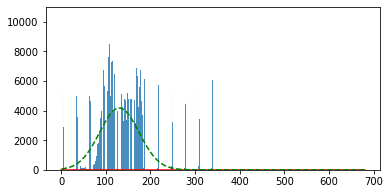

-- India
2.979647e+01 4.302136e+02


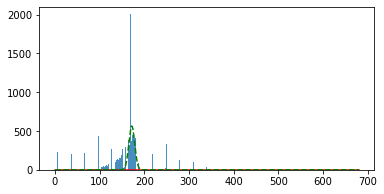

-- United States
3.542087e+01 7.950935e+03


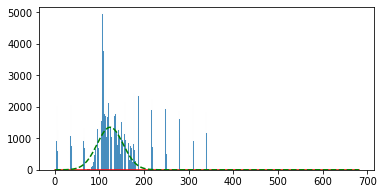

-- United Kingdom
3.369041e+01 2.180039e+03


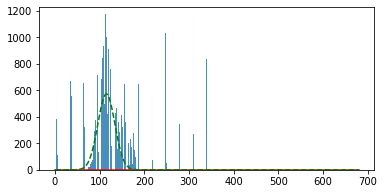

-- Italy
3.751849e+01 2.086321e+03


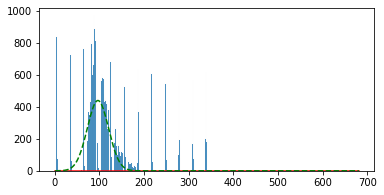

-- Australia
9.161415e+00 1.792267e+01


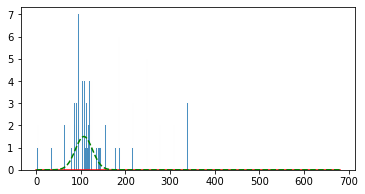

-- Canada
3.046373e+01 5.989626e+02


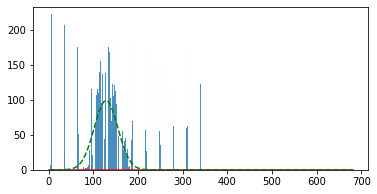

-- France
3.422703e+01 1.481617e+03


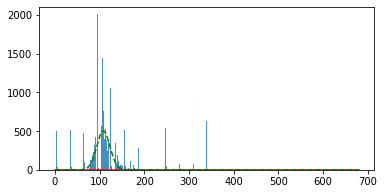

-- Germany
3.064041e+01 2.214674e+02


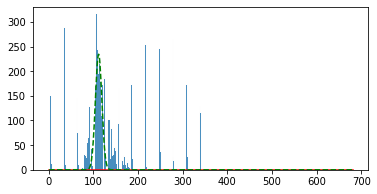

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / (np.array(y_true)+1))) * 100

insufficient = ['Central African Republic', 'Cambodia', 'Sudan', 'Ecuador'] 
finaldata = []
for country in ['World', 'India', 'United States', 'United Kingdom', 'Italy','Australia','Canada','France','Germany']:
	if country in insufficient:
		continue
	# if os.path.exists('graphs/'+country+'.pdf'): continue
	try:
		print("--", country)
		df2 = df[df['location'] == country]
		res = getInfoCountry(df2)
		# res, df2 = getSars()
		# country = 'SARS'
		data = res[-1]
		# if sum(data) < 2000 and not data in ['Brazil', 'Peru', 'Iran', 'Israel', 'Oman']:
		# 	print('skip', country,)
		# 	continue
		days = res[1]
		start = res[0]

		func = [(gauss, [0, 20, 100]), (weib, [30000, 14, 4, 500]), (ft, [3000, 0.5, 100]), (lognormal, [0, 20, 100])]

		whichFunc = 0
		times = 2
		plt.figure(figsize=(6,3))
		x = list(range(len(data)))
		datacopy = np.array(deepcopy(data[1:]))
		if country == 'China': datacopy[datacopy == 15141] = 4000
		poptg, pcovg = curve_fit(func[whichFunc][0], x[1:], datacopy, func[whichFunc][1], maxfev=10000)
		whichFunc = 3
		popt = func[whichFunc][1]
		# popt, pcov = iterativeCurveFit(func[whichFunc][0], x[1:], datacopy, func[whichFunc][1])
		# finalday, finalexp = totalExpected(func[whichFunc][0], popt, data)
		# when97 = calcWhen(func[whichFunc][0], popt, 0.97 * finalexp, data)
		# # finaldayg, finalexpg = totalExpected(func[0][0], poptg, data)
		# # when97g = calcWhen(func[0][0], poptg, 0.97 * finalexpg, data)

		xlim = max(len(data)*times, 0)
		pred = [func[whichFunc][0](px, *popt) for px in list(range(xlim))[1:]]

		plt.plot(list(range(xlim))[1:], pred, color='red', label='Robust Weibull Prediction')
		plt.plot(list(range(xlim))[1:], [func[0][0](px, *poptg) for px in list(range(xlim))[1:]], '--', color='green', label='Gaussian Prediction')
		# print("MSE ", "{:e}".format(mean_squared_error(data[1:], [func[whichFunc][0](px, *popt) for px in x[1:]])))
		# print("R2 ", "{:e}".format(r2_score(data[1:], [func[whichFunc][0](px, *popt) for px in x[1:]])))
		# print("97 day", start + timedelta(days=when97))
		# print("final day", start + timedelta(days=finalday))
		# print("total cases", finalexp)
		_ = plt.bar(x, data, width=1, edgecolor='black', linewidth=0.01, alpha=0.8, label='Actual Data')
		# dt = list(df2.Date)
		# skip = 30

        # Metrics
		y = [func[whichFunc][0](px, *popt) for px in x[1:]]
		y[y == inf] = 0; y[y == -inf] = 0
		np.nan_to_num(y)
		y = np.array(np.real(y))
		y = np.nan_to_num(y)
		y = np.array(y, dtype='float64')
		mse = "{:e}".format(mean_squared_error(data[1:], y))
		mape = "{:e}".format(mean_absolute_percentage_error(data[1:], y))
		mseg = "{:e}".format(mean_squared_error(data[1:], [func[0][0](px, *poptg) for px in x[1:]]))
		mapeg = "{:e}".format(mean_absolute_percentage_error(data[1:], [func[0][0](px, *poptg) for px in x[1:]]))
		r2 = "{:e}".format(r2_score(data[1:], y))
		r2g = "{:e}".format(r2_score(data[1:], [func[0][0](px, *poptg) for px in x[1:]]))
		y = [func[whichFunc][0](px, *popt) for px in x[1:]]
		maxcases = "{:e}".format(max(y))
		maxday = y.index(max(y))
		print(mape, mapeg)
		finaldata.append([country, mse, mseg, r2, r2g, mape, mapeg])
		# plt.xticks(list(range(0,xlim,30)), [(start+timedelta(days=i)).strftime("%b %d") for i in range(0,xlim,skip)], rotation=45, ha='right')
		# style = dict( arrowstyle = "-" ,  connectionstyle = "angle", ls =  'dashed')
		# text = plt.annotate('97\% of Total\nPredicted cases\non '+(start+timedelta(days=when97)).strftime("%d %b %Y"), xy = ( when97 , 0 ), size='x-small', ha='center', xytext=( when97 , 3*func[whichFunc][0](when97, *popt)), bbox=dict(boxstyle='round', facecolor='white', alpha=0.25), xycoords = 'data' , textcoords = 'data' , fontSize = 16 , arrowprops = style ) 
		# text.set_fontsize(10)
		# text2 = plt.annotate('(Gaussian)\n97\% of Total\nPredicted cases\non '+(start+timedelta(days=when97g)).strftime("%d %b %Y"), xy = ( when97g , 0 ), size='x-small', ha='center', xytext=( when97g , 3*func[whichFunc][0](when97, *popt)+4000), bbox=dict(boxstyle='round', facecolor='white', alpha=0.25), xycoords = 'data' , textcoords = 'data' , fontSize = 16 , arrowprops = style ) 
		# text2.set_fontsize(10)
		# plt.ylabel("New Cases")
		# plt.xlabel("Date")
		# plt.legend()
		# plt.tight_layout()
		# plt.savefig('graphs/'+country+'.pdf')
		plt.show()
		#print(location)
	except Exception as e:
		print(str(e))
		raise e
		pass
params = ['peaks diff', 'total cases', 'total deaths', 'cases/pop', 'deaths/pop', 'mortality']
df = pd.DataFrame(finaldata,columns=['Country','MSE', 'MSE Gaussian', 'R2', 'R2 Gaussian', 'MAPE', 'MAPE Gaussian'])
df.to_excel('scores.xlsx')



In [45]:
##############miscs#############

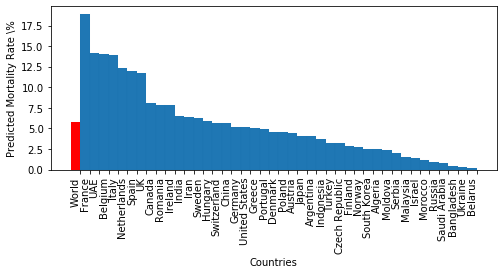

In [46]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import mean_squared_error
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy
import torch.nn.functional as F
from numpy import inf
from math import exp
from datetime import timedelta
from sklearn.metrics import r2_score
from scipy.special import softmax
import warnings
import os

warnings.simplefilter("ignore")



df = pd.read_excel('misc.xlsx')
countries = df['Country']
data = df['Mortality rate']

plt.figure(figsize=(8,3))
bars = plt.bar(list(range(len(data))), data, width=1, edgecolor='black', linewidth=0.01, alpha=1, label='Mortality Rate %')
bars[0].set_color('r')
bars[0].set_edgecolor('k')
plt.xticks([i+0.5 for i in list(range(len(data)))], countries, rotation=90, ha='right')

plt.xlabel('Countries')
plt.ylabel('Predicted Mortality Rate \%')

plt.savefig('mortality.pdf')